In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as pf
import numpy as np
import matplotlib.pyplot as plt
import glob
import tqdm

from scipy.ndimage.filters import gaussian_filter
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy.signal import savgol_filter

import warnings
import os
import sys
warnings.filterwarnings("ignore")



In [2]:
plt.style.use('notebook')

In [3]:
#--- iSpec directory -------------------------------------------------------------
# ispec_dir = os.path.dirname(os.path.realpath(__file__)) + "/"
ispec_dir = '/Users/daniel/iSpec/'
sys.path.insert(0, os.path.abspath(ispec_dir))
import ispec

In [4]:

import logging
LOG_LEVEL = "error"
logger = logging.getLogger() # root logger, common for all
logger.setLevel(logging.getLevelName(LOG_LEVEL.upper()))

In [5]:
# plt.style.use('notebook')
spectra_dir = 'data/Spectra/SONG/'

In [6]:
# synth_spec = 'data/Spectra/SOPHIE/SS_AlphaDra_final_4400_4600.norm'
# synth_wav, synth_flux = np.loadtxt(synth_spec, usecols=(0,1)).T
# np.savetxt('synthesis/harps_synth.txt', list(zip(synth_wav / 10, synth_flux, np.ones_like(synth_flux) * 0.01)))

# harps_synth = ispec.read_spectrum('synthesis/harps_synth.txt')

# plt.plot(harps_synth['waveobs'], harps_synth['flux'])

In [226]:
from scipy import interpolate
from scipy.interpolate import UnivariateSpline

def smooth(x, y, factor=0.1):
    df = x[1] - x[0]
    return gaussian_filter(y, factor / df)

def flatten(x, y, return_trend=False):
    m = y < np.percentile(y, 95)
    p = np.polyfit(x[m], y[m], 3)
    if return_trend:
        return y / np.polyval(p, x), np.polyval(p, x)
    return y / np.polyval(p, x)

def interpolate_spectrum(x, y, template_wav):
    f1  = interpolate.interp1d(x, y, kind = 'linear')
    return f1(template_wav)
    
def estimate_background(x, y, log_width=0.01):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

def fit_continuum(x, y, ivars, order=6, nsigma=[0.3,3.0], maxniter=50):
    """Fit the continuum using sigma clipping
    Args:
        x: The wavelengths
        y: The log-fluxes
        order: The polynomial order to use
        nsigma: The sigma clipping threshold: tuple (low, high)
        maxniter: The maximum number of iterations to do
    Returns:
        The value of the continuum at the wavelengths in x
    """
    A = np.vander(x - np.nanmean(x), order+1)
    m = np.ones(len(x), dtype=bool)
    for i in range(maxniter):
        m[ivars == 0] = 0  # mask out the bad pixels
        w = np.linalg.solve(np.dot(A[m].T, A[m]), np.dot(A[m].T, y[m]))
        mu = np.dot(A, w)
        resid = y - mu
        sigma = np.sqrt(np.nanmedian(resid**2))
        #m_new = np.abs(resid) < nsigma*sigma
        m_new = (resid > -nsigma[0]*sigma) & (resid < nsigma[1]*sigma)
        if m.sum() == m_new.sum():
            m = m_new
            break
        m = m_new
    return mu


def flatten(x, y, k=5):
    m = y < np.percentile(y, 95)
    p = np.polyfit(x[m], y[m], k)
    return y / np.polyval(p, x)

In [288]:
def get_spectrum(spec, orders):
    spec_data = pf.getdata(spec)
    wav = spec_data[3,:,:]
    flux = spec_data[0,:,:]# / spec_data[2,:,:]
    
    all_wav, all_flux = [], []
    
    wmax = 0
    for w, f in zip(wav[orders], flux[orders]):
        m = w  > wmax
        w, f = w[m], f[m]
#         print(w)
        
        ivars = np.ones_like(w)
        mu = fit_continuum(w, f, ivars, order=10)
        f /= mu
#         f = flatten(w, f)
#         f = smooth(w, f)
        all_wav.extend(w)
        all_flux.extend(f)
        wmax = w[-1]

    all_wav, all_flux = np.array(all_wav), np.array(all_flux)
    all_flux /= np.median(all_flux)
#     all_flux = smooth(all_wav, all_flux, factor=0.01)
    return all_wav, all_flux

In [289]:
wav_shift = np.loadtxt('data/RV/wav_shifts.txt', usecols=(0)).T

In [290]:
wav

array([4382.6123694 , 4382.63396898, 4382.65556557, ..., 5586.77077082,
       5586.79161278, 5586.81245218])

In [291]:
all_spectra_files = np.array(sorted(glob.glob(spectra_dir + '*.fits')))
epochs = np.arange(len(all_spectra_files))
m = ~((epochs == 60) | (epochs == 15))
all_spectra_files = all_spectra_files[m]

orders = [18,19,20,21,22,23,24,25,26]
orders= [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
#18,19,20,21,22,23,24,25,

wavelengths = np.arange(wav.min()/10 + 3, wav.max()/10 - 3, 0.002) # 0.2 A
resampled = []

for i, spec in tqdm.tqdm(enumerate(all_spectra_files[:]), total=len(all_spectra_files)):

    wav, flux = get_spectrum(spec, orders)
    meta = pf.getheader( spec )
    times.append(meta['BJD-MID'])
    
    m = wav < np.inf
    wav, flux = wav[m], flux[m]
    flux /= np.median(flux)
    
#     np.savetxt(f"cleaned/{spec.split('/')[-1].split('.')[0]}.txt", list(zip(wav / 10, flux, np.ones_like(flux) * 0.01)))
#     star_spectrum = ispec.read_spectrum(f"cleaned/{spec.split('/')[-1].split('.')[0]}.txt")
    star_spectrum = ispec.create_spectrum_structure(wav / 10)
    star_spectrum['flux'] = flux
    
#     all_spectra.append(star_spectrum)
    resampled.append(np.array(interpolate_spectrum(star_spectrum['waveobs'] + wav_shift[i], 
                                                   star_spectrum['flux'], 
                                                   wavelengths)))
#     plt.plot(star_spectrum['waveobs'], star_spectrum['flux'] - i * 0.1, lw=0.7)
# plt.xlim(450, 456)

resampled = np.array(resampled)
# plt.xlim(451, 452)

100%|██████████| 59/59 [00:08<00:00,  7.32it/s]


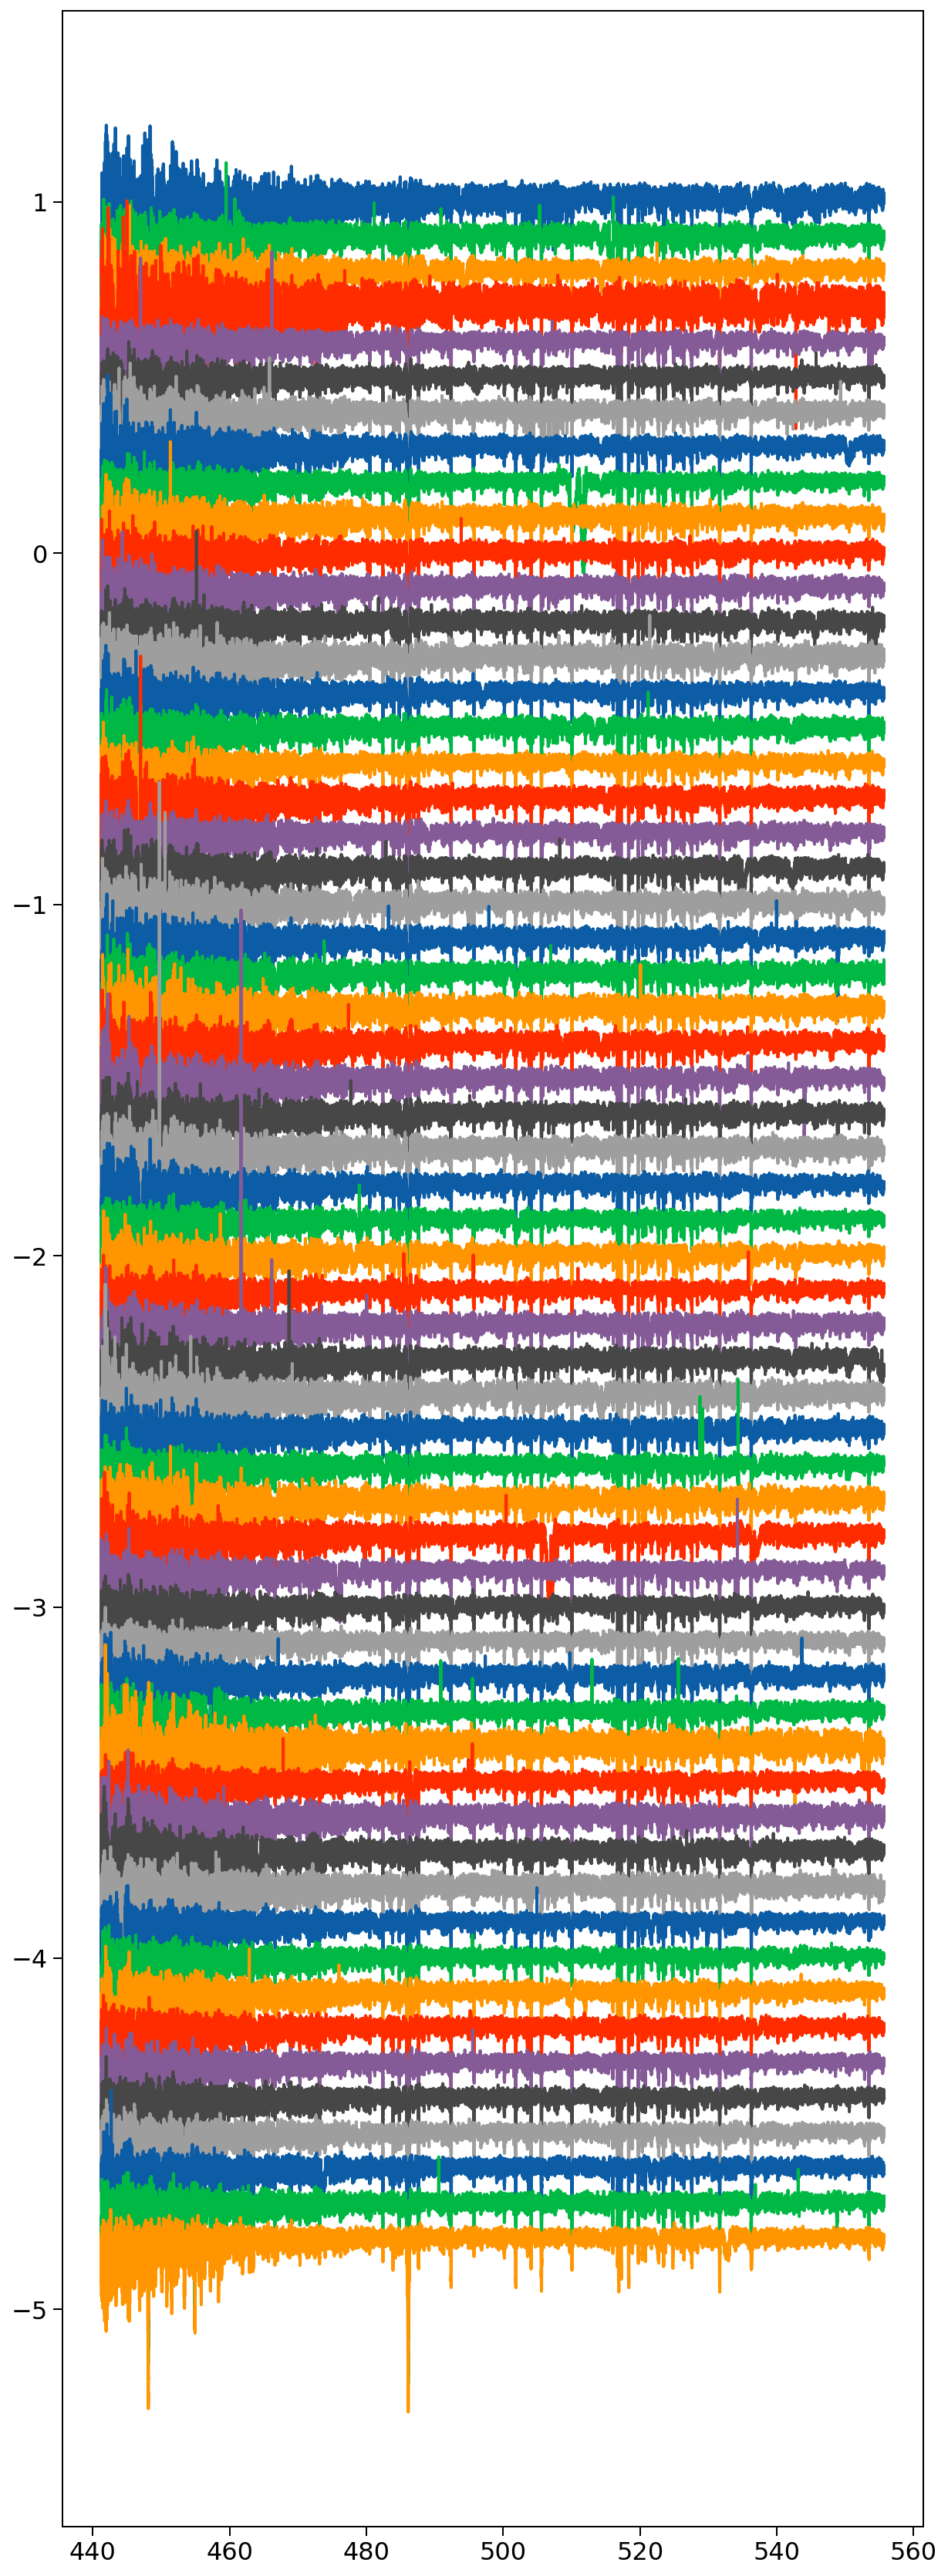

In [292]:

plt.figure(figsize=[10,30])
for i in range(len(resampled)):
    plt.plot(
        wavelengths, 
        resampled[i] - i * 0.1, label=i)
    
# plt.legend()
    
# plt.xlim(454.5, 455)

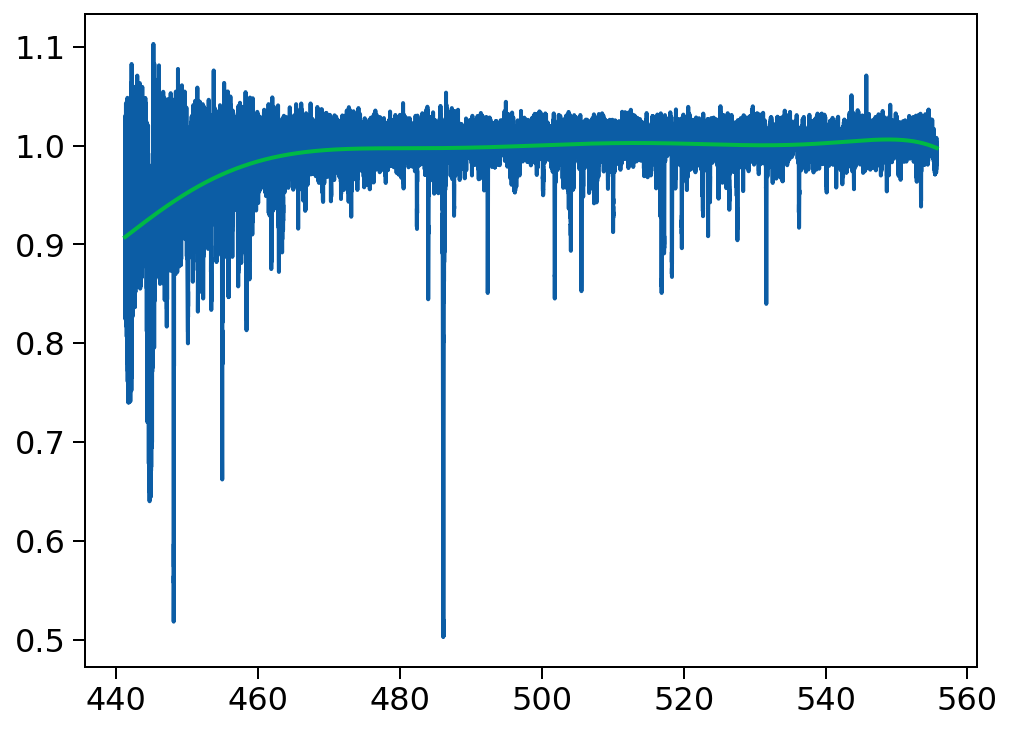

In [308]:
plt.plot(wavelengths, resampled[5])
p = np.polyfit(wavelengths, resampled[5], 10)
plt.plot(wavelengths, np.polyval(p, wavelengths))

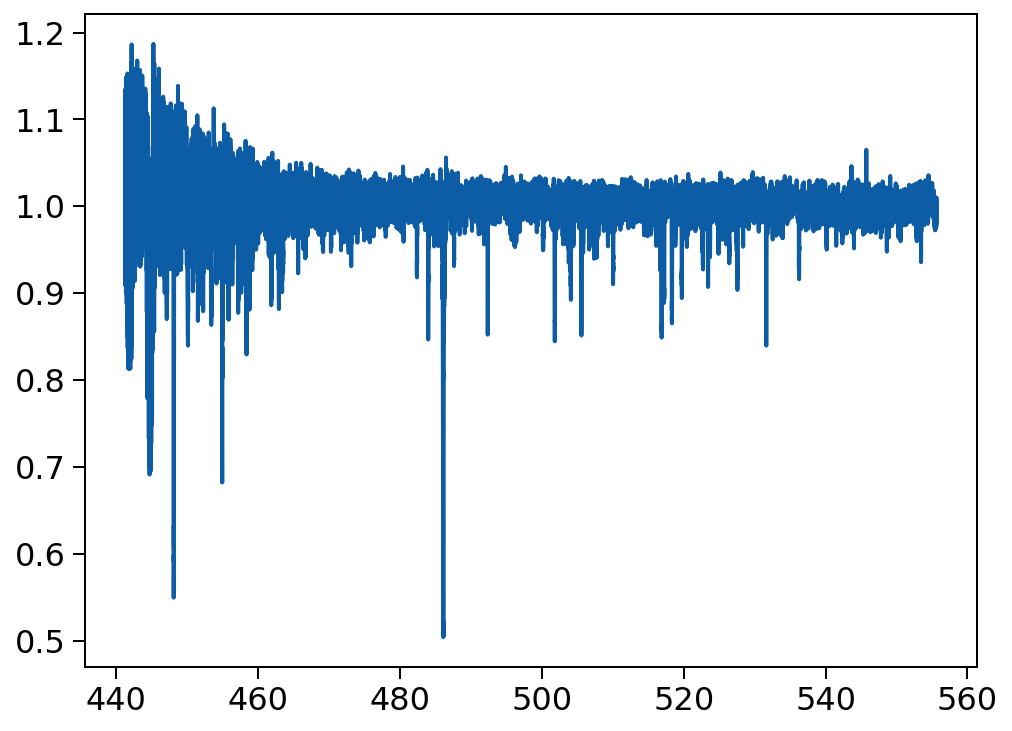

In [309]:
plt.plot(wavelengths, resampled[5] / np.polyval(p, wavelengths))

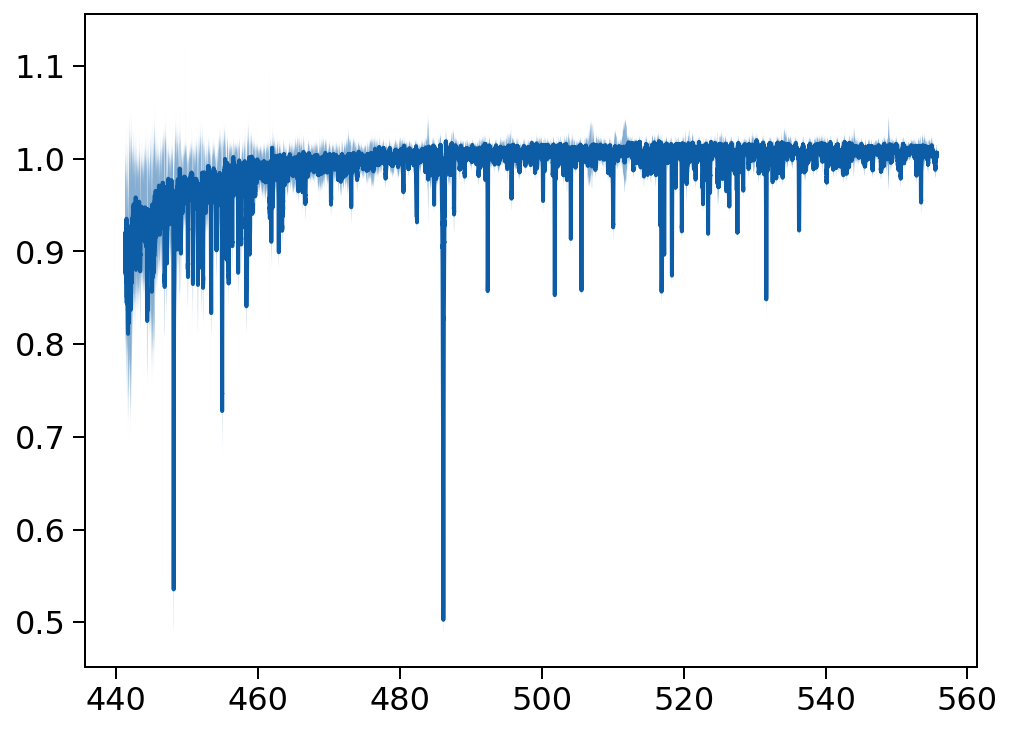

In [294]:
def estimate_background(x, y, log_width=0.05):
    count = np.zeros(len(x), dtype=int)
    bkg = np.zeros_like(x)
    x0 = np.log10(x[0])
    while x0 < np.log10(x[-1]):
        m = np.abs(np.log10(x) - x0) < log_width
        bkg[m] += np.median(y[m])
        count[m] += 1
        x0 += 0.5 * log_width
    return bkg / count

med = np.median(resampled,axis=0)
sd = np.std(resampled,axis=0)
# med = flatten(wavelengths, med, k=8)
# med = smooth(wavelengths, med, factor=0.001)

plt.plot(wavelengths,med)
plt.fill_between(wavelengths, med-sd, med+sd, alpha=0.5)


(440.0, 450.0)

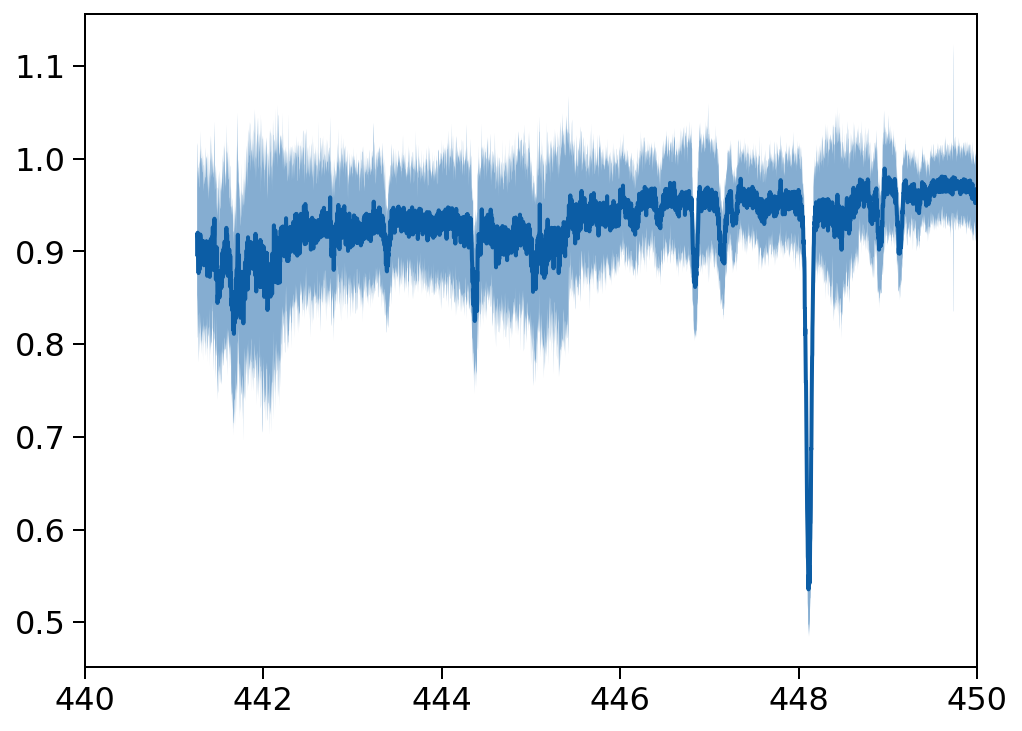

In [296]:
plt.plot(wavelengths,med)
plt.fill_between(wavelengths, med-sd, med+sd, alpha=0.5)
plt.xlim(440, 450)

In [131]:
star_spectrum = ispec.create_spectrum_structure(wavelengths)
star_spectrum['flux'] = np.median(resampled,axis=0) / bkg
star_spectrum['err'] = np.std(resampled,axis=0)

In [132]:
# star_spectrum = ispec.read_spectrum(f"data/Spectra/primary_stacked.txt")

# def smooth(x, y, factor=0.05):
#     df = x[1] - x[0]
#     return gaussian_filter(y, factor / df)

# def estimate_background(x, y, log_width=0.05):
#     count = np.zeros(len(x), dtype=int)
#     bkg = np.zeros_like(x)
#     x0 = np.log10(x[0])
#     while x0 < np.log10(x[-1]):
#         m = np.abs(np.log10(x) - x0) < log_width
#         bkg[m] += np.median(y[m])
#         count[m] += 1
#         x0 += 0.5 * log_width
#     return bkg / count

# bkg = estimate_background(star_spectrum['waveobs'], star_spectrum['flux'], log_width=0.00015)
# # cont = fit_continuum(star_spectrum['waveobs'], np.log(star_spectrum['waveobs']), ivars=np.ones_like(star_spectrum['waveobs']))
# # star_spectrum['flux'] /= bkg
# # plt.plot(star_spectrum['waveobs'], star_spectrum['flux'] / bkg)

# # star_spectrum['flux'] = smooth(star_spectrum['waveobs'], star_spectrum['flux'])
# # plt.plot(star_spectrum['waveobs'], star_spectrum['flux'])
# # plt.plot(star_spectrum['waveobs'], bkg)


# # star_spectrum['flux'] /= bkg

# m = star_spectrum['flux'] < 0.975
# star_spectrum_cut = ispec.create_spectrum_structure(star_spectrum['waveobs'][m])
# star_spectrum_cut['flux'], star_spectrum_cut['err'] = star_spectrum['flux'][m], star_spectrum['err'][m]

# plt.plot(star_spectrum_cut['waveobs'], star_spectrum_cut['flux'])

In [133]:
# plt.plot(harps_synth['waveobs'], harps_synth['flux'])
# plt.plot(star_spectrum['waveobs'], star_spectrum['flux'])

# # plt.xlim(440, 460)

In [134]:
#--- Synthesizing spectrum -----------------------------------------------------
# Parameters
# teff = 9975
# logg = 3.63
# MH = -0.56
# alpha = ispec.determine_abundance_enchancements(MH)
# microturbulence_vel = 0.#ispec.estimate_vmic(teff, logg, MH) # 1.07
# macroturbulence = 0.#ispec.estimate_vmac(teff, logg, MH) # 4.21
# vsini = 26. # Sun
limb_darkening_coeff = 0.6
resolution = 100000
wave_step = 0.001

# Wavelengths to synthesis
wave_base = star_spectrum['waveobs'].min()
wave_top = star_spectrum['waveobs'].max()

# Load up all the models
model = ispec_dir + "/input/atmospheres/ATLAS9.Castelli/"
# atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.300_1100nm/atomic_lines.tsv"
atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_hfs_iso.420_920nm/atomic_lines.tsv"
isotope_file = ispec_dir + "/input/isotopes/SPECTRUM.lst"

# Load chemical information and linelist
atomic_linelist = ispec.read_atomic_linelist(atomic_linelist_file, wave_base=wave_base, wave_top=wave_top)
atomic_linelist = atomic_linelist[atomic_linelist['theoretical_depth'] >= 0.01] # Select lines that have some minimal contribution in the sun

isotopes = ispec.read_isotope_data(isotope_file)
solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.1998/stdatom.dat"

# Load model atmospheres
modeled_layers_pack = ispec.load_modeled_layers_pack(model)
# Load SPECTRUM abundances
solar_abundances = ispec.read_solar_abundances(solar_abundances_file)


In [135]:
def synthesise_spectrum(wav, teff, logg, MH, microturbulence_vel, macroturbulence, vsini, alpha,
                       code='turbospectrum', fixed_abundances=None, regions=None):

    # Prepare atmosphere model
    atmosphere_layers = ispec.interpolate_atmosphere_layers(modeled_layers_pack, {'teff':teff, 'logg':logg, 'MH':MH, 'alpha':alpha}, code=code)

    # Synthesis
    synth_spectrum = ispec.create_spectrum_structure(wav)
    synth_spectrum['flux'] = ispec.generate_spectrum(wav, \
            atmosphere_layers, teff, logg, MH, alpha, atomic_linelist, isotopes, solar_abundances, \
            fixed_abundances, microturbulence_vel = microturbulence_vel, \
            macroturbulence=macroturbulence, vsini=vsini, limb_darkening_coeff=limb_darkening_coeff, \
            R=resolution, regions=regions, verbose=1,
            code=code)
    return synth_spectrum

def lnlike(params, x, y, yerr):
    teff, logg, MH, vsini, offset = params
    alpha = ispec.determine_abundance_enchancements(MH)

    if not ispec.valid_atmosphere_target(modeled_layers_pack, {'teff':teff, 'logg':logg, 'MH':MH, 'alpha':alpha}):
        msg = "The specified effective temperature, gravity (log g) and metallicity [M/H] \
                fall out of theatmospheric models."
        print(msg)
        return -1e8
    
    synth_spec = synthesise_spectrum(x + offset, teff, logg, MH, 0, 0, vsini, alpha)
#     bkg = estimate_background(synth_spec['waveobs'], synth_spec['flux'], log_width=0.0005)
#     synth_spec['flux'] /= bkg
    
#     sigma2 = yerr[1:-3]**2 + synth_spec['flux'][1:-3]**2 * np.exp(2 * logsigma)
    lnlike_val = -0.5 * np.sum((y[1:-3] - synth_spec['flux'][1:-3]) ** 2)# / sigma2 + np.log(sigma2))
    print(f"{params}, {lnlike_val:.4f}")
    return lnlike_val

nll = lambda *args: -lnlike(*args)

In [136]:
x0 = [9500, 3.3, -0.7, 26, 0]
nll(x0, star_spectrum['waveobs'], star_spectrum['flux'], star_spectrum['err'])

[9500, 3.3, -0.7, 26, 0], -0.1957


0.1957100206669738

In [137]:
from scipy.optimize import minimize

soln = minimize(nll, x0, args=(star_spectrum['waveobs'], star_spectrum['flux'], star_spectrum['err']),
               method='Nelder-Mead')

[ 9.5e+03  3.3e+00 -7.0e-01  2.6e+01  0.0e+00], -0.1957
[ 9.975e+03  3.300e+00 -7.000e-01  2.600e+01  0.000e+00], -0.1678
[ 9.500e+03  3.465e+00 -7.000e-01  2.600e+01  0.000e+00], -0.1960
[ 9.50e+03  3.30e+00 -7.35e-01  2.60e+01  0.00e+00], -0.1892
[ 9.50e+03  3.30e+00 -7.00e-01  2.73e+01  0.00e+00], -0.1872
[ 9.5e+03  3.3e+00 -7.0e-01  2.6e+01  2.5e-04], -0.1717
[ 9.690e+03  3.135e+00 -7.140e-01  2.652e+01  1.000e-04], -0.1737
[ 9.7660e+03  3.2340e+00 -7.1960e-01  2.6728e+01  1.4000e-04], -0.1625
[ 9.8990e+03  3.2010e+00 -7.2940e-01  2.7092e+01  2.1000e-04], -0.1453
[ 9.92560e+03  3.19440e+00 -6.82360e-01  2.71648e+01  2.24000e-04], -0.1436
[ 1.01384e+04  3.14160e+00 -6.56040e-01  2.77472e+01  3.36000e-04], -0.1380
[ 1.018096e+04  3.131040e+00 -6.997760e-01  2.604368e+01  3.584000e-04], -0.1446
[ 1.0187344e+04  3.2944560e+00 -6.8008640e-01  2.6633152e+01
  3.6176000e-04], -0.1445
[ 1.06522816e+04  3.12723840e+00 -6.86120960e-01  2.74064128e+01
  2.56464000e-04], -0.1637
[ 1.04481942e+

In [138]:
soln

 final_simplex: (array([[ 1.00872500e+04,  3.10750274e+00, -6.59350567e-01,
         2.77662306e+01,  3.48530794e-04],
       [ 1.00872499e+04,  3.10750275e+00, -6.59350570e-01,
         2.77662304e+01,  3.48530798e-04],
       [ 1.00872499e+04,  3.10750276e+00, -6.59350565e-01,
         2.77662304e+01,  3.48530813e-04],
       [ 1.00872499e+04,  3.10750275e+00, -6.59350573e-01,
         2.77662305e+01,  3.48530786e-04],
       [ 1.00872499e+04,  3.10750275e+00, -6.59350570e-01,
         2.77662304e+01,  3.48530793e-04],
       [ 1.00872499e+04,  3.10750274e+00, -6.59350569e-01,
         2.77662305e+01,  3.48530793e-04]]), array([0.1372519 , 0.13725202, 0.13725224, 0.1372524 , 0.13725241,
       0.1372525 ]))
           fun: 0.13725189907691743
       message: 'Optimization terminated successfully.'
          nfev: 280
           nit: 120
        status: 0
       success: True
             x: array([ 1.00872500e+04,  3.10750274e+00, -6.59350567e-01,  2.77662306e+01,
        3.48530794e

In [43]:
# test = np.array([ 1.48392528e+04,  4.50032372e+00, -6.14670337e-01,  1.20458854e+01])

9.70873500e+03  2.73217754e+00 -4.20836397e-01  2.68131356e+01

In [140]:
wav = star_spectrum['waveobs']
alpha = ispec.determine_abundance_enchancements(-6.59350567e-01)
# synth = synthesise_spectrum(wav, 1.48392528e+04, 4.5, -6.1467e-01, 0,0, 1.204e+01, alpha, code='moog')
# teff, logg, MH, microturbulence_vel, macroturbulence, vsini, alpha,
synth = synthesise_spectrum(wav, 1.00872500e+04, 3.10750274e+00, -6.59350567e-01, 0,0, 2.77662306e+01, alpha, code='turbospectrum')

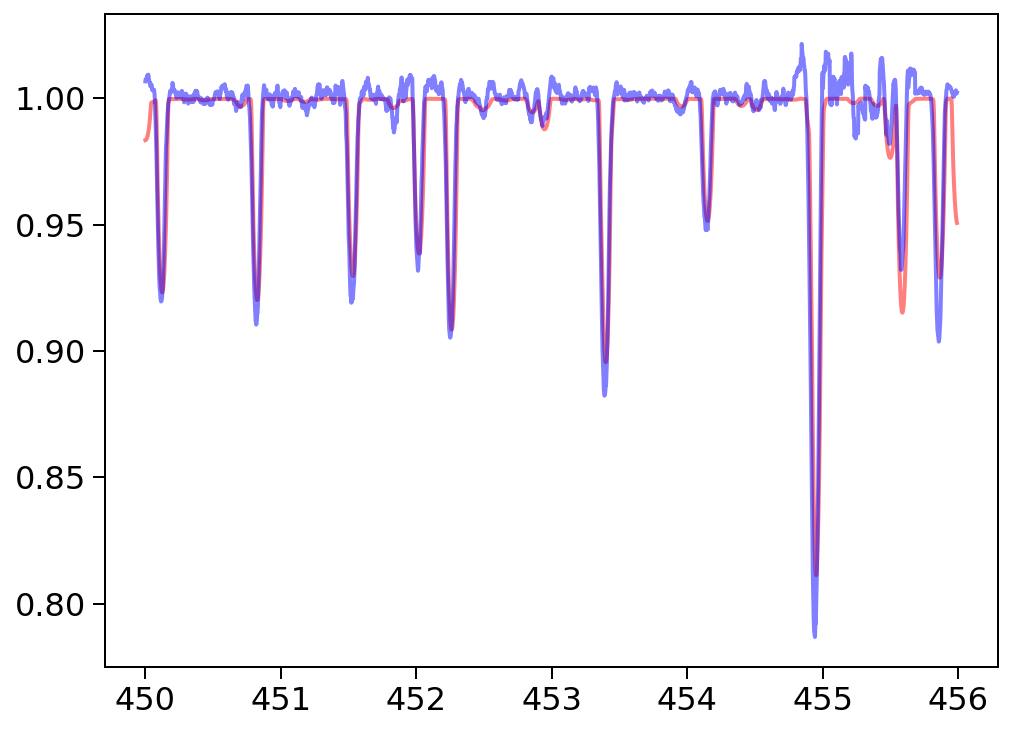

In [141]:
# bkg = estimate_background(synth['waveobs'], synth['flux'], log_width=0.0005)
plt.plot(synth['waveobs'][1:-3], synth['flux'][1:-3], alpha=0.5, c='red')
plt.plot(star_spectrum['waveobs'][1:-3], star_spectrum['flux'][1:-3], alpha=0.5, c='blue')
# plt.plot(synth['waveobs'][1:-3], bkg[1:-3], alpha=0.9)

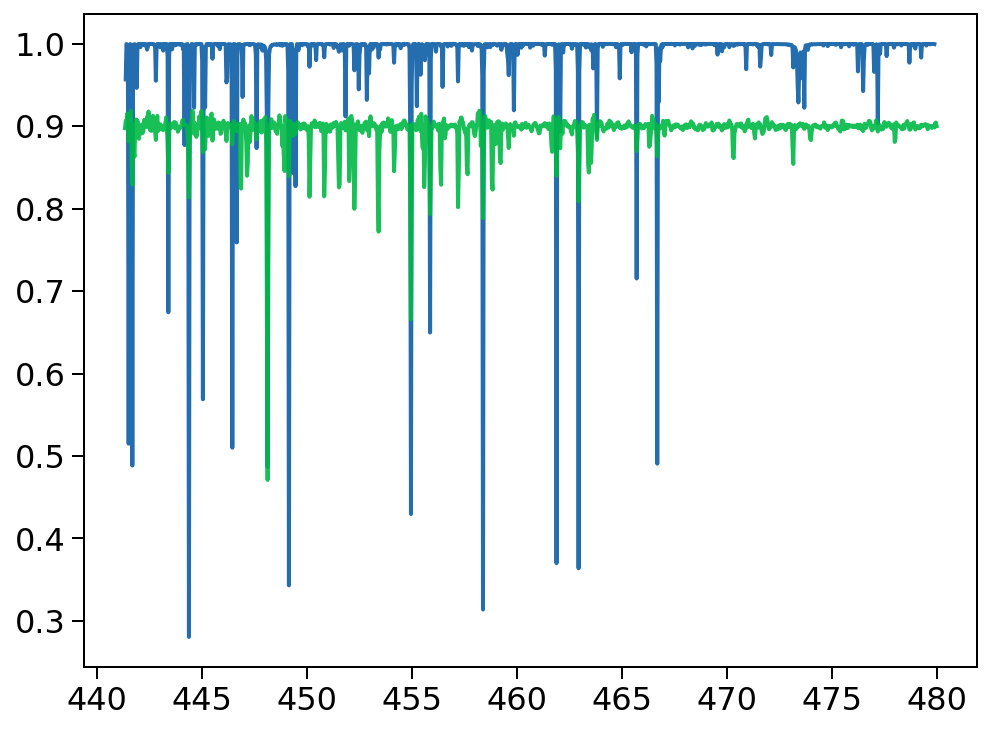

In [76]:
plt.plot(synth['waveobs'][1:-3], synth['flux'][1:-3], alpha=0.9)
plt.plot(star_spectrum['waveobs'], star_spectrum['flux'] - 0.1, alpha=0.9)

In [32]:
# %%timeit
codes = ['turbospectrum', 'moog', 'sme']
wav = star_spectrum['waveobs']

synth = []
for code in codes:
    synth.append(synthesise_spectrum(wav, teff, logg, MH, 0, 0, 26, code=code))

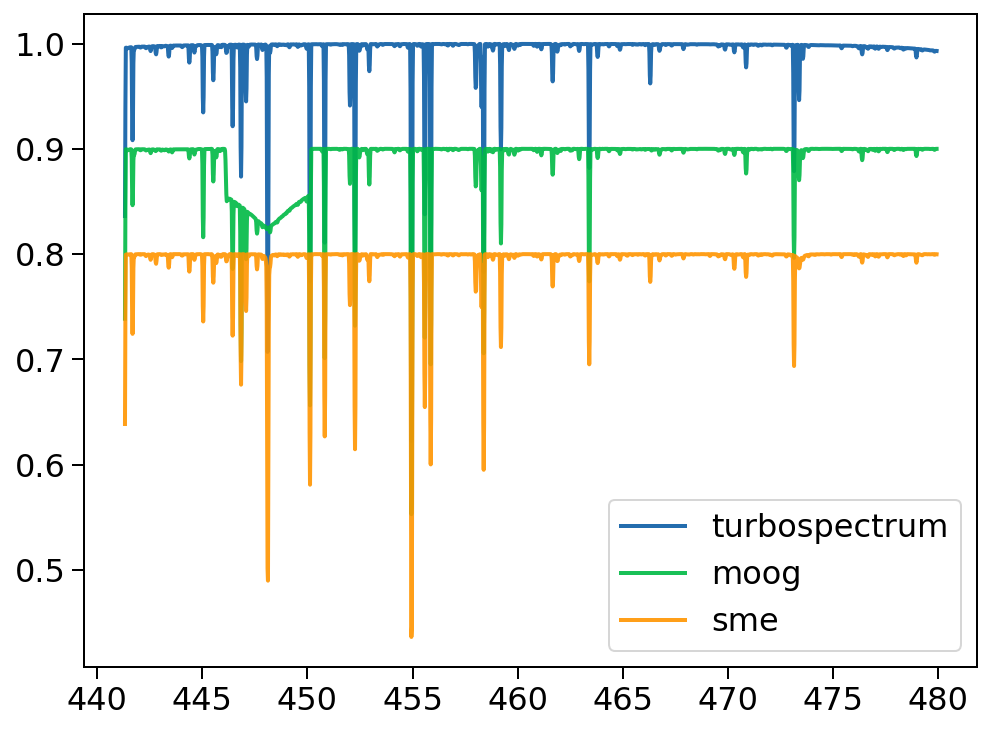

In [34]:
for i in range(len(synth)):
    plt.plot(synth[i]['waveobs'][1:-3], synth[i]['flux'][1:-3] - i*0.1, alpha=0.9, label=codes[i])
    
plt.legend()

# Turbospectrum it is!

In [10]:
wav = star_spectrum['waveobs']

In [20]:
ranges = np.recarray((2,),  dtype=[('teff', int), ('logg', float), ('MH', float), ('alpha', float), ('vmic', float)])
ranges['teff'][0] = 10100
ranges['logg'][0] = 4.
ranges['MH'][0] = 0.
ranges['alpha'][0] = 0.0
ranges['vmic'][0] = ispec.estimate_vmic(ranges['teff'][0], ranges['logg'][0], ranges['MH'][0])
ranges['teff'][1] = 8500
ranges['logg'][1] = 1.5
ranges['MH'][1] = -0.8
ranges['alpha'][1] = 0.0
ranges['vmic'][1] = ispec.estimate_vmic(ranges['teff'][1], ranges['logg'][1], ranges['MH'][1])

In [42]:
teff = np.linspace(8500, 10100, 50)
logg = np.linspace(2.5, 3.7, 5)
MH = np.linspace(-0.9, 0., 5)

a, b = np.meshgrid(teff, logg)


In [43]:
ranges = np.recarray((2,),  dtype=[('teff', int), ('logg', float), ('MH', float), ('alpha', float), ('vmic', float)])



In [58]:
teff = np.linspace(8500, 10100, 50)
logg = np.linspace(2.5, 3.7, 5)
MH = np.linspace(-0.9, 0., 5)

teff, logg, mh, d  = np.meshgrid(teff, logg, MH, 0)

In [60]:
len(d.flatten())

1250

In [57]:
len(mh.flatten())

1250

In [61]:
def precompute_synthetic_grid(code="turbospectrum"):
    precomputed_grid_dir = "synthesis/grid/"

    ## - Read grid ranges from file
    #from astropy.io import ascii
    #ranges_filename = "input/minigrid/initial_estimate_grid_ranges.tsv"
    #ranges = ascii.read(ranges_filename, delimiter="\t")
    ## - or define them directly here (example of only 2 reference points):
    
#     ranges = np.recarray((2,),  dtype=[('teff', int), ('logg', float), ('MH', float), ('alpha', float), ('vmic', float)])
#     ranges['teff'][0] = 10100
#     ranges['logg'][0] = 4.
#     ranges['MH'][0] = 0.
#     ranges['alpha'][0] = 0.0
#     ranges['vmic'][0] = ispec.estimate_vmic(ranges['teff'][0], ranges['logg'][0], ranges['MH'][0])
#     ranges['teff'][1] = 8500
#     ranges['logg'][1] = 1.5
#     ranges['MH'][1] = -0.8
#     ranges['alpha'][1] = 0.0
#     ranges['vmic'][1] = ispec.estimate_vmic(ranges['teff'][1], ranges['logg'][1], ranges['MH'][1])

    teff = np.linspace(8500, 10100, 50)
    logg = np.linspace(2.5, 3.7, 5)
    MH = np.linspace(-0.9, 0., 5)
#     vmic = np.linspace(0, 10, 5)
    
    teff, logg, mh, alpha, vmic = np.meshgrid(teff, logg, MH, 0, 0)
    ranges = np.recarray((len(teff.flatten()),),  dtype=[('teff', int), ('logg', float), ('MH', float), ('alpha', float), ('vmic', float)])
    ranges['teff'] = teff.flatten()
    ranges['logg'] = logg.flatten()
    ranges['MH'] = mh.flatten()
    ranges['alpha'] = alpha.flatten()
    ranges['vmic'] = vmic.flatten()

    # Wavelengths
    #initial_wave = 480.0
    #final_wave = 680.0
    wavelengths = wav#np.arange(initial_wave, final_wave, step_wave)
    initial_wave = wav.min()
    final_wave = wav.max()

    to_resolution = 80000 # Individual files will not be convolved but the grid will be (for fast comparison)
    number_of_processes = 4 # It can be parallelized for computers with multiple processors


    # Selected model amtosphere, linelist and solar abundances
    #model = ispec_dir + "/input/atmospheres/MARCS/"
#     model = ispec_dir + "/input/atmospheres/MARCS.GES/"
    #model = ispec_dir + "/input/atmospheres/MARCS.APOGEE/"
    #model = ispec_dir + "/input/atmospheres/ATLAS9.APOGEE/"
    model = ispec_dir + "/input/atmospheres/ATLAS9.Castelli/"
    #model = ispec_dir + "/input/atmospheres/ATLAS9.Kurucz/"
    #model = ispec_dir + "/input/atmospheres/ATLAS9.Kirby/"

    atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.300_1100nm/atomic_lines.tsv"
    #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.1100_2400nm/atomic_lines.tsv"
#     atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_hfs_iso.420_920nm/atomic_lines.tsv"
    #atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_nohfs_noiso.420_920nm/atomic_lines.tsv"

    isotope_file = ispec_dir + "/input/isotopes/SPECTRUM.lst"

    # Load chemical information and linelist
    atomic_linelist = ispec.read_atomic_linelist(atomic_linelist_file, wave_base=initial_wave, wave_top=final_wave)
    atomic_linelist = atomic_linelist[atomic_linelist['theoretical_depth'] >= 0.01] # Select lines that have some minimal contribution in the sun

    isotopes = ispec.read_isotope_data(isotope_file)

    if "ATLAS" in model:
        solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.1998/stdatom.dat"
    else:
        # MARCS
        solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.2007/stdatom.dat"
    #solar_abundances_file = ispec_dir + "/input/abundances/Asplund.2005/stdatom.dat"
    #solar_abundances_file = ispec_dir + "/input/abundances/Asplund.2009/stdatom.dat"
    #solar_abundances_file = ispec_dir + "/input/abundances/Anders.1989/stdatom.dat"

    # Load model atmospheres
    modeled_layers_pack = ispec.load_modeled_layers_pack(model)
    # Load SPECTRUM abundances
    solar_abundances = ispec.read_solar_abundances(solar_abundances_file)

    ## Custom fixed abundances
    #fixed_abundances = ispec.create_free_abundances_structure(["C", "N", "O"], chemical_elements, solar_abundances)
    #fixed_abundances['Abund'] = [-3.49, -3.71, -3.54] # Abundances in SPECTRUM scale (i.e., x - 12.0 - 0.036) and in the same order ["C", "N", "O"]
    ## No fixed abundances
    fixed_abundances = None


    ispec.precompute_synthetic_grid(precomputed_grid_dir, ranges, wavelengths, to_resolution, \
                                    modeled_layers_pack, atomic_linelist, isotopes, solar_abundances, \
                                    segments=None, number_of_processes=number_of_processes, \
                                    code=code, steps=False)

In [ ]:
precompute_synthetic_grid()

[started] 8500 2.5 -0.9 [started]0.0  85000.0  0.02.5  -0.6750.0  0.00.0  0.00 
0.0 0.0 0.0 0
[started] 8500 2.5 -0.45 0.0 0.0 0.0 0.0 [started] 0.08500  2.50 -0.22499999999999998 0.0
 0.0 0.0 0.0 0.0 0
[finished][finished]  8500 2.58500 -0.675 0.0  0.0 2.50.0  0.0-0.9  0.0 0.00.0 0.0 0.0  00.0 
0
[finished] 8500 2.5 -0.22499999999999998 0.0 0.0 0.0 0.0 0.0 0
[finished] 8500 2.5 -0.45 0.0 0.0 0.0 0.0[started] 0.0  0
8500 2.5[started] 0.0  0.08532 0.0  0.02.5  0.0-0.9  0.00.0  0
0.0 0.0 0.0 0.0 0
[started] 8532 2.5 -0.675 0.0 0.0 0.0 0.0 0.0 0
[started] 8532 2.5 -0.45 0.0 0.0 0.0 0.0 0.0 0
[finished] 8532 2.5 -0.9 0.0 0.0 0.0 0.0 0.0 0
[finished] 8532 2.5 -0.675 0.0 0.0 0.0 0.0 0.0 0
[started] [finished] 8532 85322.5 -0.45 0.0  0.0 2.50.0 0.0  0.0 0
-0.22499999999999998 0.0 0.0 0.0 0.0 0.0 0
[started] 8532 2.5 0.0 0.0 0.0 0.0 0.0 0.0 0
[started] 8565 2.5 -0.9 0.0 0.0 0.0 0.0 0.0 0
[finished] 8500 2.5 0.0 0.0 0.0 0.0 0.0 0.0 0
[started] 8565 2.5 -0.675 0.0 0.0 0.0 0.0 0.0 0
[finished] 85

Process ForkPoolWorker-9:


In [199]:


# Selected model amtosphere, linelist and solar abundances
#model = ispec_dir + "/input/atmospheres/MARCS/"
# model = ispec_dir + "/input/atmospheres/MARCS.GES/"
#model = ispec_dir + "/input/atmospheres/MARCS.APOGEE/"
#model = ispec_dir + "/input/atmospheres/ATLAS9.APOGEE/"
model = ispec_dir + "/input/atmospheres/ATLAS9.Castelli/"
# model = ispec_dir + "/input/atmospheres/ATLAS9.Kurucz/"
# model = ispec_dir + "/input/abundances/ATLAS9.Kurucz/"
#model = ispec_dir + "/input/atmospheres/ATLAS9.Kirby/"

atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.300_1100nm/atomic_lines.tsv"
#atomic_linelist_file = ispec_dir + "/input/linelists/transitions/VALD.1100_2400nm/atomic_lines.tsv"
# atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_hfs_iso.420_920nm/atomic_lines.tsv"
#atomic_linelist_file = ispec_dir + "/input/linelists/transitions/GESv6_atom_nohfs_noiso.420_920nm/atomic_lines.tsv"

isotope_file = ispec_dir + "/input/isotopes/SPECTRUM.lst"

# Load chemical information and linelist
atomic_linelist = ispec.read_atomic_linelist(atomic_linelist_file, wave_base=wave_base, wave_top=wave_top)
atomic_linelist = atomic_linelist[atomic_linelist['theoretical_depth'] >= 0.01] # Select lines that have some minimal contribution in the sun

isotopes = ispec.read_isotope_data(isotope_file)

if "ATLAS" in model:
    solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.1998/stdatom.dat"
else:
    # MARCS
    solar_abundances_file = ispec_dir + "/input/abundances/Grevesse.2007/stdatom.dat"
#solar_abundances_file = ispec_dir + "/input/abundances/Asplund.2005/stdatom.dat"
# solar_abundances_file = ispec_dir + "/input/abundances/Asplund.2009/stdatom.dat"
#solar_abundances_file = ispec_dir + "/input/abundances/Anders.1989/stdatom.dat"

# Load model atmospheres
modeled_layers_pack = ispec.load_modeled_layers_pack(model)
# Load SPECTRUM abundances
solar_abundances = ispec.read_solar_abundances(solar_abundances_file)

## Custom fixed abundances
#fixed_abundances = ispec.create_free_abundances_structure(["C", "N", "O"], chemical_elements, solar_abundances)
#fixed_abundances['Abund'] = [-3.49, -3.71, -3.54] # Abundances in SPECTRUM scale (i.e., x - 12.0 - 0.036) and in the same order ["C", "N", "O"]
## No fixed abundances
fixed_abundances = None

# Validate parameters
if not ispec.valid_atmosphere_target(modeled_layers_pack, {'teff':teff, 'logg':logg, 'MH':MH, 'alpha':alpha}):
    msg = "The specified effective temperature, gravity (log g) and metallicity [M/H] \
            fall out of theatmospheric models."
    print(msg)

# Prepare atmosphere model
atmosphere_layers = ispec.interpolate_atmosphere_layers(modeled_layers_pack, {'teff':teff, 'logg':logg, 'MH':MH, 'alpha':alpha}, code=code)

# Synthesis
synth_spectrum = ispec.create_spectrum_structure(star_spectrum['waveobs'])
synth_spectrum['flux'] = ispec.generate_spectrum(synth_spectrum['waveobs'], \
        atmosphere_layers, teff, logg, MH, alpha, atomic_linelist, isotopes, solar_abundances, \
        fixed_abundances, microturbulence_vel = microturbulence_vel, \
        macroturbulence=macroturbulence, vsini=vsini, limb_darkening_coeff=limb_darkening_coeff, \
        R=resolution, regions=regions, verbose=1,
        code=code)
##--- Save spectrum ------------------------------------------------------------
# logging.info("Saving spectrum...")
# synth_filename = "example_synth_%s.fits" % (code)
# ispec.write_spectrum(synth_spectrum, synth_filename)

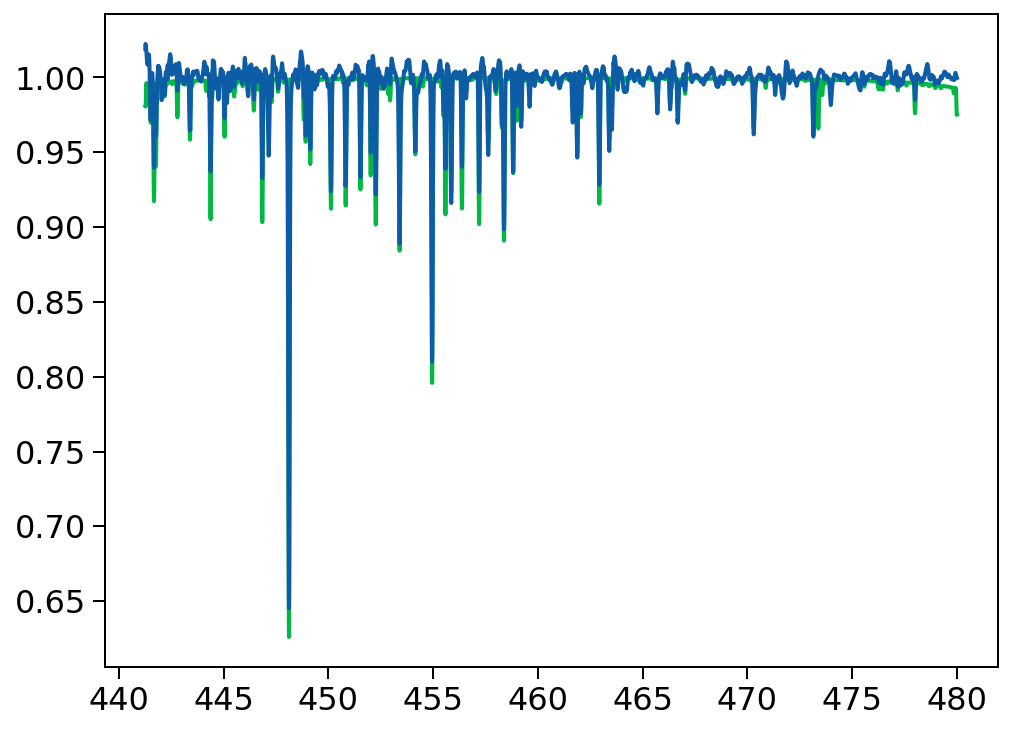

In [202]:
plt.plot(synth_spectrum['waveobs'][1:-3], synth_spectrum['flux'][1:-3], c='C1', alpha=1)
plt.plot(star_spectrum['waveobs'], star_spectrum['flux'],alpha=1)

# plt.xlim(447, 450)

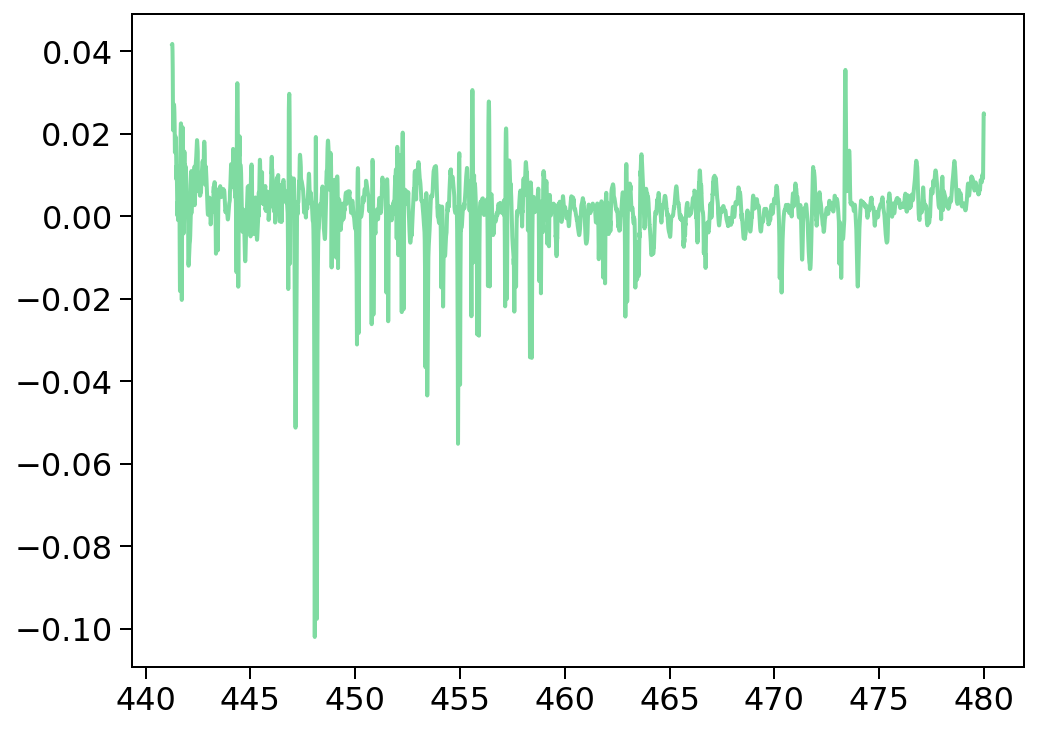

In [201]:
plt.plot(synth_spectrum['waveobs'][1:-3], star_spectrum['flux'][1:-3] - synth_spectrum['flux'][1:-3], c='C1', alpha=0.5)

In [87]:
len(star_spectrum['flux'])

6140